# Alternate Z02FH Analysis Approach

In [69]:
import re
def ExtractTC(x):
    return re.search("_D(\d{3})",x)[1]

print(ExtractTC('MB_U01_MZ02F_D420'))

def ExtractUUT(x):
    return "U"+re.search("_U(\d{2})",x)[1]
    
print(ExtractUUT('MB_U01_MZ02F_D420'))


def Maccor_parser(x):
    days = float(re.search("(.+?)d",x)[1])
    hours= re.search("(?<=d)(.*)",x)[1].strip()
    h =    float(re.search("(\d*)(?=:)",hours)[1])
    m =    float(re.search("(?<=:)(\d*)",hours)[1])
    s =    float(re.search("(?<=:\d\d:)(.*)",hours)[1])
    return (days*1440+h*60+m+s/60)/60

print(Maccor_parser('4d 22:25:6.53000020980835')) # Test pattern

420
U01
118.41848055561383


In [70]:
# This is an intersting alternate approach for reading in the battery data
import glob
import os
import pandas as pd
from pathlib import Path
from functools import partial

prs = partial(pd.read_csv, 
              sep="\t", 
              header=0, 
              skiprows=4, 
              usecols=['Rec#','Cyc#','Step','TestTime','StepTime','Amp-hr','Amps','Volts','State']
             )
path=os.path.join(os.getcwd(), "Z02_Test")  # This reminds me of what I have to do with PQ
files = Path(path).glob('*.txt')            # Making a path object provides all sorts of great methods

df = pd.concat((prs(f).assign(filename=f.stem) for f in files), ignore_index=True)
df.StepTime=df.StepTime.apply(Maccor_parser)
df.TestTime=df.TestTime.apply(Maccor_parser)
df= (df
 .assign(UUT = lambda x:x['filename'].apply(ExtractUUT),
         TC  = lambda x:x['filename'].apply(ExtractTC)
        )
 .drop('filename',axis=1)
 .rename(columns={"filename": "Test_Case","Rec#":"Rec","Cyc#":"Cyc"})
 .set_index('Rec')    
    )

In [71]:
df

,Cyc,Step,TestTime,StepTime,Amp-hr,Amps,Volts,State,UUT,TC
Rec,,,,,,,,,,
1,0,1,0.000000,0.000000,0.00000,0.0000,3.79103,R,U01,420
2,0,1,0.016667,0.016667,0.00000,0.0000,3.79118,R,U01,420
3,1,4,0.016667,0.000000,0.00000,0.0005,3.78630,P,U01,420
4,1,5,0.016669,0.000003,0.00000,0.0000,3.79042,D,U01,420
5,1,5,0.033336,0.016669,0.00001,0.0005,3.78233,D,U01,420
...,...,...,...,...,...,...,...,...,...,...
7139,5,5,118.418481,12.300011,0.00615,0.0005,3.85199,D,U03,435
7140,5,5,118.435147,12.316678,0.00616,0.0005,3.85168,D,U03,435
7141,5,5,118.451814,12.333344,0.00617,0.0005,3.85130,D,U03,435


In [72]:
df = df.query("Cyc==2 and State=='D' and Step==5")


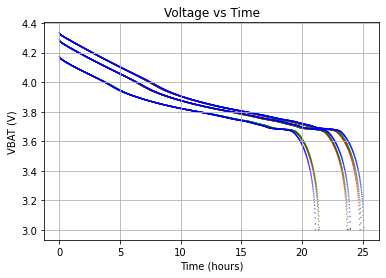

In [75]:
import matplotlib.pyplot as plt
zz = {'U01':'red','U02':'green','U03':'blue'}
df.plot.scatter(x='StepTime',
                y='Volts',
                c=df['UUT'].map(zz),
                s=0.1)
plt.title('Voltage vs Time')
plt.xlabel('Time (hours)')
plt.ylabel('VBAT (V)')
plt.grid()